In [ ]:
pip install yfinance

In [8]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from pandas_datareader import data as pdr

[*********************100%%**********************]  5 of 5 completed


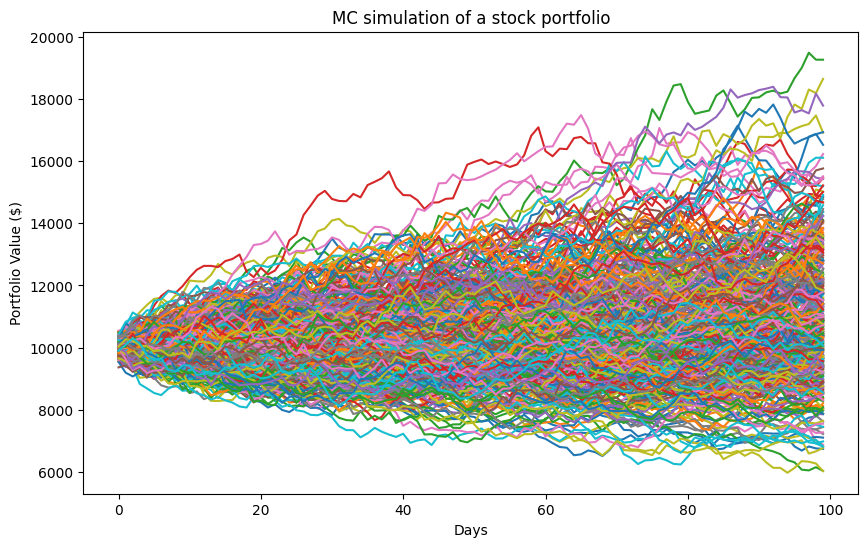

VaR $2034.37
CVaR $2865.48


In [10]:
# Define the function to get data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Define the function for portfolio performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns * weights) * Time
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return returns, std

# Define the function for historical VaR
def historicalVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")

# Define the function for historical CVaR
def historicalCVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")

# Define the function for parametric VaR
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100) * portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

# Define the function for parametric CVaR
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100)) * portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

# Define the function for Monte Carlo VaR
def mcVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

# Define the function for Monte Carlo CVaR
def mcCVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

# Define the stock tickers
tickers = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*2)

# Get the data
returns, meanReturns, covMatrix = getData(tickers, start=startDate, end=endDate)
returns = returns.dropna()

# Initialize random weights
weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

# Portfolio returns
returns['portfolio'] = returns.dot(weights)

# Monte Carlo Method
mc_sims = 400  # number of simulations
T = 100  # timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio

# Plot Monte Carlo simulations
plt.figure(figsize=(10, 6))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

# Calculate VaR and CVaR using Monte Carlo simulation
portResults = pd.Series(portfolio_sims[-1, :])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR, 2)))
print('CVaR ${}'.format(round(CVaR, 2)))
